#  <center> <font style="color:rgb(100,109,254)">Making Computer Vision Game Bots  </font> </center>
In this notebook we'll see how we can combine Template Matching with Pyautogui to built some interesting Video Game Bots. You can take this same concept and either built your own bots or perform Vision powered GUI automation.

In [1]:
import pyautogui as pyg
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

## <font style="color:rgb(134,19,348)"> Google Dino Game </font>
We are now going to built a game that will play the Google dino game (The one you play when Internet goes down 🤕)

Now there are several objects that the dino need to avoid, like several type of spikes and that crow, lets load them all up from our folder named dinor, we'll use all these pictures as templates

In [2]:
obstacles = []
for image in glob.glob("media/M4/dinor/*.png"):
    obstacles.append(cv2.imread(image,0))  

**You can see all obstacles below**

In [3]:
rows = np.ceil(len(obstacles)/3)
plt.figure(figsize=[7,7])    
for index, obstacle in enumerate(obstacles,1):
    plt.subplot(rows,3,index);plt.imshow(obstacle,cmap='gray');
    plt.title("Obstacle: {}".format(index));plt.axis('off')  

<Figure size 504x504 with 0 Axes>

**Here is our Dino**
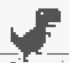

## [Play Dino Game here](http://www.trex-game.skipser.com/)

In [4]:
def find_dino():
    while True:         
        image = pyg.screenshot()
        # Convert PIL image to numpy format and also RGB to BGR
        img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        dino_location =  pyg.locateOnScreen('Media/M4/dinopic.jpg' , confidence=0.90)
        if dino_location is not None:
            # we will get the right corner x location of the bounding box of our dinosour
            return dino_location[0], dino_location[1], dino_location[2], dino_location[3]

##  <font style="color:rgb(134,19,348)"> Estimating the Detection Area </font>
Its really inefficient to search for the dinosaur on the whole screen When we know we only have to look a specific area on the screen to find it, so now we'll just use the detected dinosaur coordinates and some heuristics to estimate the area to perform detection, the estimation also makes sure that the code works regardless of where the dinosaur is on the screen.

In [ ]:
initial_x, initial_y, width, height = find_dino()

y1 = initial_y - 2 * height 
y2 = initial_y + height
x1 = initial_x - width
x2 = initial_x + 13 * width

image = pyg.screenshot()
img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

estimated_roi = img[y1:y2, x1:x2]  

plt.figure(figsize=[10,10])    
plt.imshow(estimated_roi);

## <font style="color:rgb(134,19,348)">Test Detection of Obstacles </font>
Check if your obstacle templates are being successfully detected, also record this as a video

In [ ]:
initial_x, initial_y, width, height = find_dino()

y1 = initial_y - 2 * height 
y2 = initial_y + height
x1 = initial_x - width
x2 = initial_x + 13 * width

# This is the confidence for template matching
thresh = 0.55

fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Set the fps according to your PC, what you're trying to do here is analize the and set the parameters
out = cv2.VideoWriter(r'media/M4/dino_recording.mp4',fourcc, 10.0, (x2-x1,y2-y1))

while True:
 
    image = pyg.screenshot()
    img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    estimated_roi = img[y1:y2, x1:x2].copy()

    allx=[]
    gray_img = cv2.cvtColor(estimated_roi, cv2.COLOR_BGR2GRAY)
   
    for template in obstacles:
        result = cv2.matchTemplate(gray_img, template,cv2.TM_CCOEFF_NORMED)
        
        loc = np.where(result >= thresh)
        
        for pt in zip(*loc):
            top_left = pt[::-1]
            top_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
            cv2.rectangle(estimated_roi, top_left, top_right, (0, 255, 0), 2) 
            # Appending the x position only, since we only care how close obstacle are in x direction.
            allx.append(top_left[0])             
            break 
        
    if allx:                   
        cv2.putText(estimated_roi, 'Distance: {} '.format(np.sort(allx)[0]), (10, 13),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=0.5,color=(0, 0, 255))    
        
                       
    cv2.imshow('image_result',estimated_roi)
    out.write(estimated_roi)
    
    k = cv2.waitKey(1)
    if k == 27:   
        break
        
cv2.destroyAllWindows()
out.release()

## <font style="color:rgb(134,19,348)">Adding Logic for Jumping </font>
Now After seeing that our obstacles are being detected we will add logic for the dinosaur to jump, from the above script I have determined that a good threshold to jump would be `260` for my case, (Your's might be different). Now I will just add the following 2 lines to the above script to make the dinosaur jump.

```if np.sort(allx)[0] <  jump:
         pyg.press('up') ```
                
Which just says if the distance of closest obstacle to the dino is less than our defined threshold then press up (meaning jump).

In [ ]:
initial_x, initial_y, width, height = find_dino()

y1 = initial_y - 2 * height 
y2 = initial_y + height
x1 = initial_x - width
x2 = initial_x + 13 * width

thresh = 0.55

# This is the distance at which we will jump
jump = 260

fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Set the fps according to your PC, what you're trying to do here is analize the and set the parameters
out = cv2.VideoWriter(r'media/M4/dino_recording.mp4',fourcc, 10.0, (x2-x1,y2-y1))

while True:
 
    image = pyg.screenshot()
    img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    estimated_roi = img[y1:y2, x1:x2].copy()

    allx=[]
    gray_img = cv2.cvtColor(estimated_roi, cv2.COLOR_BGR2GRAY)
   
    for template in obstacles:
        result = cv2.matchTemplate(gray_img, template,cv2.TM_CCOEFF_NORMED)
        
        loc = np.where(result >= thresh)
        
        for pt in zip(*loc):
            top_left = pt[::-1]
            top_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
            cv2.rectangle(estimated_roi, top_left, top_right, (0, 255, 0), 2) 
            allx.append(top_left[0]) #appending the x position only 
            
            break 
        
    if allx:   

        if np.sort(allx)[0] <  jump:
                pyg.press('up')
                
        cv2.putText(estimated_roi, 'Distance: {} '.format(np.sort(allx)[0]), (10, 13),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=0.5,color=(0, 0, 255))    
        
                       
    cv2.imshow('image_result',estimated_roi)
    out.write(estimated_roi)
    
    k = cv2.waitKey(1)
    if k == 27:   
        break
        
cv2.destroyAllWindows()
out.release()

## <font style="color:rgb(134,19,348)"> Ways to Improve the above Bot </font>
- Crop the pictures of obstacles yourself, and notice the examples that are being missed and add more of them.
- Try using masks for obstacle examples since, it will get rid of background (May give better results).
- Instead of using template matching to detect obstacles you can use contour detection.
- Duck when you detect Crow at a certain height.
- Check for the canvas to go dark and then use another obstacle list, (This list will contain the same obstacles but inverted), this way you can even get along when it goes dark.
- Most Importantly Map the Jump variable as a function of time, so as the time increases (so does the speed of incoming obstacles) your dinosaur jumps. So in simple terms you will have to decrease the distance for jumping when the time increases as obstacles will be coming at you at a faster speed.

###  <font style="color:rgb(34,169,134)"> Assignment: Upgrading Dino Bot </font>
Improve the above Dino Bot using at least 3 or more techniques mentioned above, Kudos to you if you can take this to superhuman performance and beyond.

In [ ]:
### ADD CODE HERE



## <font style="color:rgb(134,19,348)">Making a Shooting Bot </font>
Now lets make another simple Game Bot, this time we are going to make a simple shooting Bot which will shoot watermelons, And this time we will see the real advantage of a bot as it will perform better than any human on this game.

Here is the template for the watermelon:

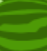

## [Play the Game here](https://scratch.mit.edu/projects/313306691/)

In [ ]:
target = cv2.imread("media/M4/watermelon.png", 0)

# Gr
y,x = pyg.size()

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(r'media/M4/guns.mp4',fourcc, 10.0, (y,x))

thresh = 0.45
                      
while True:
 
    image = pyg.screenshot()
    img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
   
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    result = cv2.matchTemplate(gray_img, target ,cv2.TM_CCOEFF_NORMED)
    loc = np.where(result >= 0.45)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    if max_val >= thresh:
        pt = max_loc
        cv2.rectangle(img, (pt[0] , pt[1] ), (pt[0] + target.shape[1], pt[1] + target.shape[0] ), (255, 145, 67), 2)  
        cv2.putText(img,'Hit here',(pt[0] , pt[1]  + 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)
        pyg.click(x=pt[0], y=pt[1])
                      
    cv2.putText(img,'After Image processing',(0,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,25,155), 2, cv2.LINE_AA)
    cv2.imshow('result',cv2.resize(img, (0,0), fx=0.8, fy=0.8) )

    out.write(img)
    k = cv2.waitKey(1)
    if k == 27:   
        break
        
cv2.destroyAllWindows()
out.release()

**Note:** When things go wild, for e.g. you put in a low confidence score then your mouse will start clicking things all over, One easy to get out of that situation is to take your mouse to the top left corner of the screen this will trigger a built in failsafe mechanism in pyautogui, which will exit the program. Another way is to stop the program by hitting the stop button but if can't control the mouse if will be harder to do that. 

###  <font style="color:rgb(34,169,134)"> Assignment: Your Own Gaming Bot</font>
Now that you're familiar with the automation tools and how to use it to built a gaming bots, you should built your own bot and make it perform better than a human. You can choose any game from the Internet. 

In [ ]:
### ADD CODE HERE

